In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import RandomizedSearchCV

# Functions

In [2]:
#This function considers outliers as values that are greater than twice the 99th percentile value 
#and values that are less than half of the 1st percentile value.
def outliers(df):
    descriptive_stats = df.describe(percentiles=[0.01, 0.99])
    higher_99 = []
    lower_01 = []
    
    # Identificar columnas con valores mayores al percentil 99 o menores al percentil 01
    for col in df.columns:
        max_val = descriptive_stats.loc['max', col]
        percentile_99 = descriptive_stats.loc['99%', col]
        min_val = descriptive_stats.loc['min', col]
        percentile_01 = descriptive_stats.loc['1%', col]
    
        if max_val > 2 * percentile_99:
            higher_99.append(col)
    
        if min_val < percentile_01 / 2:
            lower_01.append(col)
    
    print("Variables cuyo máximo es mayor al doble del percentil 99:", higher_99)
    print("Variables cuyo mínimo es menor a la mitad del percentil 01:", lower_01)
    
    # Filtrar filas con valores atípicos
    for col in higher_99:
        threshold = descriptive_stats.loc['99%', col]
        df = df[df[col] <= threshold]
    
    for col in lower_01:
        threshold = descriptive_stats.loc['1%', col]
        df = df[df[col] >= threshold]
    
    return df

# Data

In [3]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')

In [4]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


# Feature Engineering

In [5]:
df.dtypes

date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week #week of the year

In [8]:
df.sample(5)

,date,meantemp,humidity,wind_speed,meanpressure,month,year,week
402,2014-02-07,19.625000,67.250,15.0500,1009.250000,2,2014,6
201,2013-07-21,28.200000,88.000,2.2400,996.400000,7,2013,29
1438,2016-12-09,19.416667,68.125,1.3125,1013.416667,12,2016,49
40,2013-02-10,15.250000,71.500,3.4750,1017.125000,2,2013,6
569,2014-07-24,30.500000,63.625,12.0375,998.714286,7,2014,30


In [9]:
grouped = df.groupby(['week', 'year']).agg({
    'meantemp': ['max', 'min', 'mean'],
    'humidity': ['max', 'min', 'mean'],
    'wind_speed': ['max', 'min', 'mean'],
    'meanpressure': ['max', 'min', 'mean'],
    'month': ['median']
})

grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

grouped = grouped.reset_index()

In [10]:
df = grouped.sort_values(by=['year', 'week'])

In [11]:
df.head(7)

,week,year,meantemp_max,meantemp_min,meantemp_mean,humidity_max,humidity_min,humidity_mean,wind_speed_max,wind_speed_min,wind_speed_mean,meanpressure_max,meanpressure_min,meanpressure_mean,month_median
0,1,2013,14.500000,6.000000,9.138542,92.000000,71.333333,84.167708,6.475000,0.000000,3.170521,1020.500000,1015.666667,1017.803125,1.0
4,2,2013,15.833333,7.000000,12.343537,78.600000,51.250000,65.145238,13.228571,4.633333,8.825170,1020.000000,1013.333333,1016.632653,1.0
8,3,2013,16.500000,11.285714,13.642857,92.166667,71.857143,81.663265,8.950000,0.000000,4.242857,1021.666667,1014.500000,1017.139456,1.0
12,4,2013,14.000000,9.500000,12.329592,79.666667,60.166667,67.748299,6.800000,2.220000,4.770544,1021.800000,1018.142857,1020.337075,1.0
16,5,2013,18.000000,14.125000,15.736905,77.571429,56.000000,67.667347,3.700000,1.057143,2.337194,1018.400000,1015.285714,1017.020578,1.0
20,6,2013,17.428571,14.000000,15.856973,92.375000,59.400000,71.515476,11.114286,3.475000,8.885986,1018.666667,1014.571429,1017.048299,2.0
24,7,2013,19.166667,13.666667,16.012755,92.714286,63.833333,74.693878,10.183333,0.000000,5.975680,1017.500000,1008.000000,1013.785714,2.0


In [12]:
df.columns

Index(['week', 'year', 'meantemp_max', 'meantemp_min', 'meantemp_mean',
       'humidity_max', 'humidity_min', 'humidity_mean', 'wind_speed_max',
       'wind_speed_min', 'wind_speed_mean', 'meanpressure_max',
       'meanpressure_min', 'meanpressure_mean', 'month_median'],
      dtype='object')

In [13]:
cols = ['week', 'month_median', 'meantemp_max', 'meantemp_min', 'meantemp_mean',
       'humidity_max', 'humidity_min', 'humidity_mean', 'wind_speed_max',
       'wind_speed_min', 'wind_speed_mean', 'meanpressure_max',
       'meanpressure_min', 'meanpressure_mean']

# Data Cleaning

## Missings

In [14]:
df.isna().sum()

week                 0
year                 0
meantemp_max         0
meantemp_min         0
meantemp_mean        0
humidity_max         0
humidity_min         0
humidity_mean        0
wind_speed_max       0
wind_speed_min       0
wind_speed_mean      0
meanpressure_max     0
meanpressure_min     0
meanpressure_mean    0
month_median         0
dtype: int64

## Outliers

In [15]:
df[cols].describe(percentiles=[0.01, 0.02, 0.05, 0.50, 0.95, 0.98, 0.99])

,week,month_median,meantemp_max,meantemp_min,meantemp_mean,humidity_max,humidity_min,humidity_mean,wind_speed_max,wind_speed_min,wind_speed_mean,meanpressure_max,meanpressure_min,meanpressure_mean
count,211.0,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,26.872038,6.450237,27.355832,23.361866,25.374880,71.427801,51.699950,61.012768,12.123941,2.826929,6.759206,1045.328198,991.102541,1011.174944
std,15.256153,3.497092,7.370552,7.110357,7.273393,16.074901,15.491013,15.284553,5.793128,2.088073,2.839961,460.130112,111.283350,68.327648
min,1.0,1.000000,10.000000,6.000000,9.138542,27.428571,13.428571,22.816497,0.000000,0.000000,0.000000,996.375000,-3.041667,856.704401
1%,1.0,1.000000,12.912500,9.050000,10.119643,32.160000,18.520000,25.773278,3.261250,0.000000,1.301811,997.631250,342.783750,905.769975
2%,2.0,1.000000,13.400000,9.525000,12.172279,34.740000,19.700000,27.143537,3.520000,0.000000,1.790867,998.164286,939.715833,991.278486
5%,3.0,1.000000,14.562500,11.218750,12.516879,39.758929,22.625000,31.224405,5.100000,0.000000,2.201786,999.452381,994.250000,996.569345
50%,27.0,6.000000,29.800000,25.250000,28.048980,72.875000,54.074074,62.847518,11.550000,2.550000,6.819643,1010.857143,1006.375000,1009.073955
95%,50.5,12.000000,37.334559,31.812500,34.689498,92.732143,72.205357,81.685247,21.065625,6.718750,11.416197,1021.312500,1017.062500,1019.196429
98%,52.0,12.000000,38.000000,32.725000,35.263761,95.700000,73.775000,85.940179,27.687500,7.595000,12.473163,1022.100000,1018.428571,1020.316088


In [16]:
clean_df = outliers(df[cols])
df = df.loc[clean_df.index]

Variables cuyo máximo es mayor al doble del percentil 99: ['meanpressure_max']
Variables cuyo mínimo es menor a la mitad del percentil 01: ['wind_speed_max', 'wind_speed_mean', 'meanpressure_min']


# EDA

C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shumi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

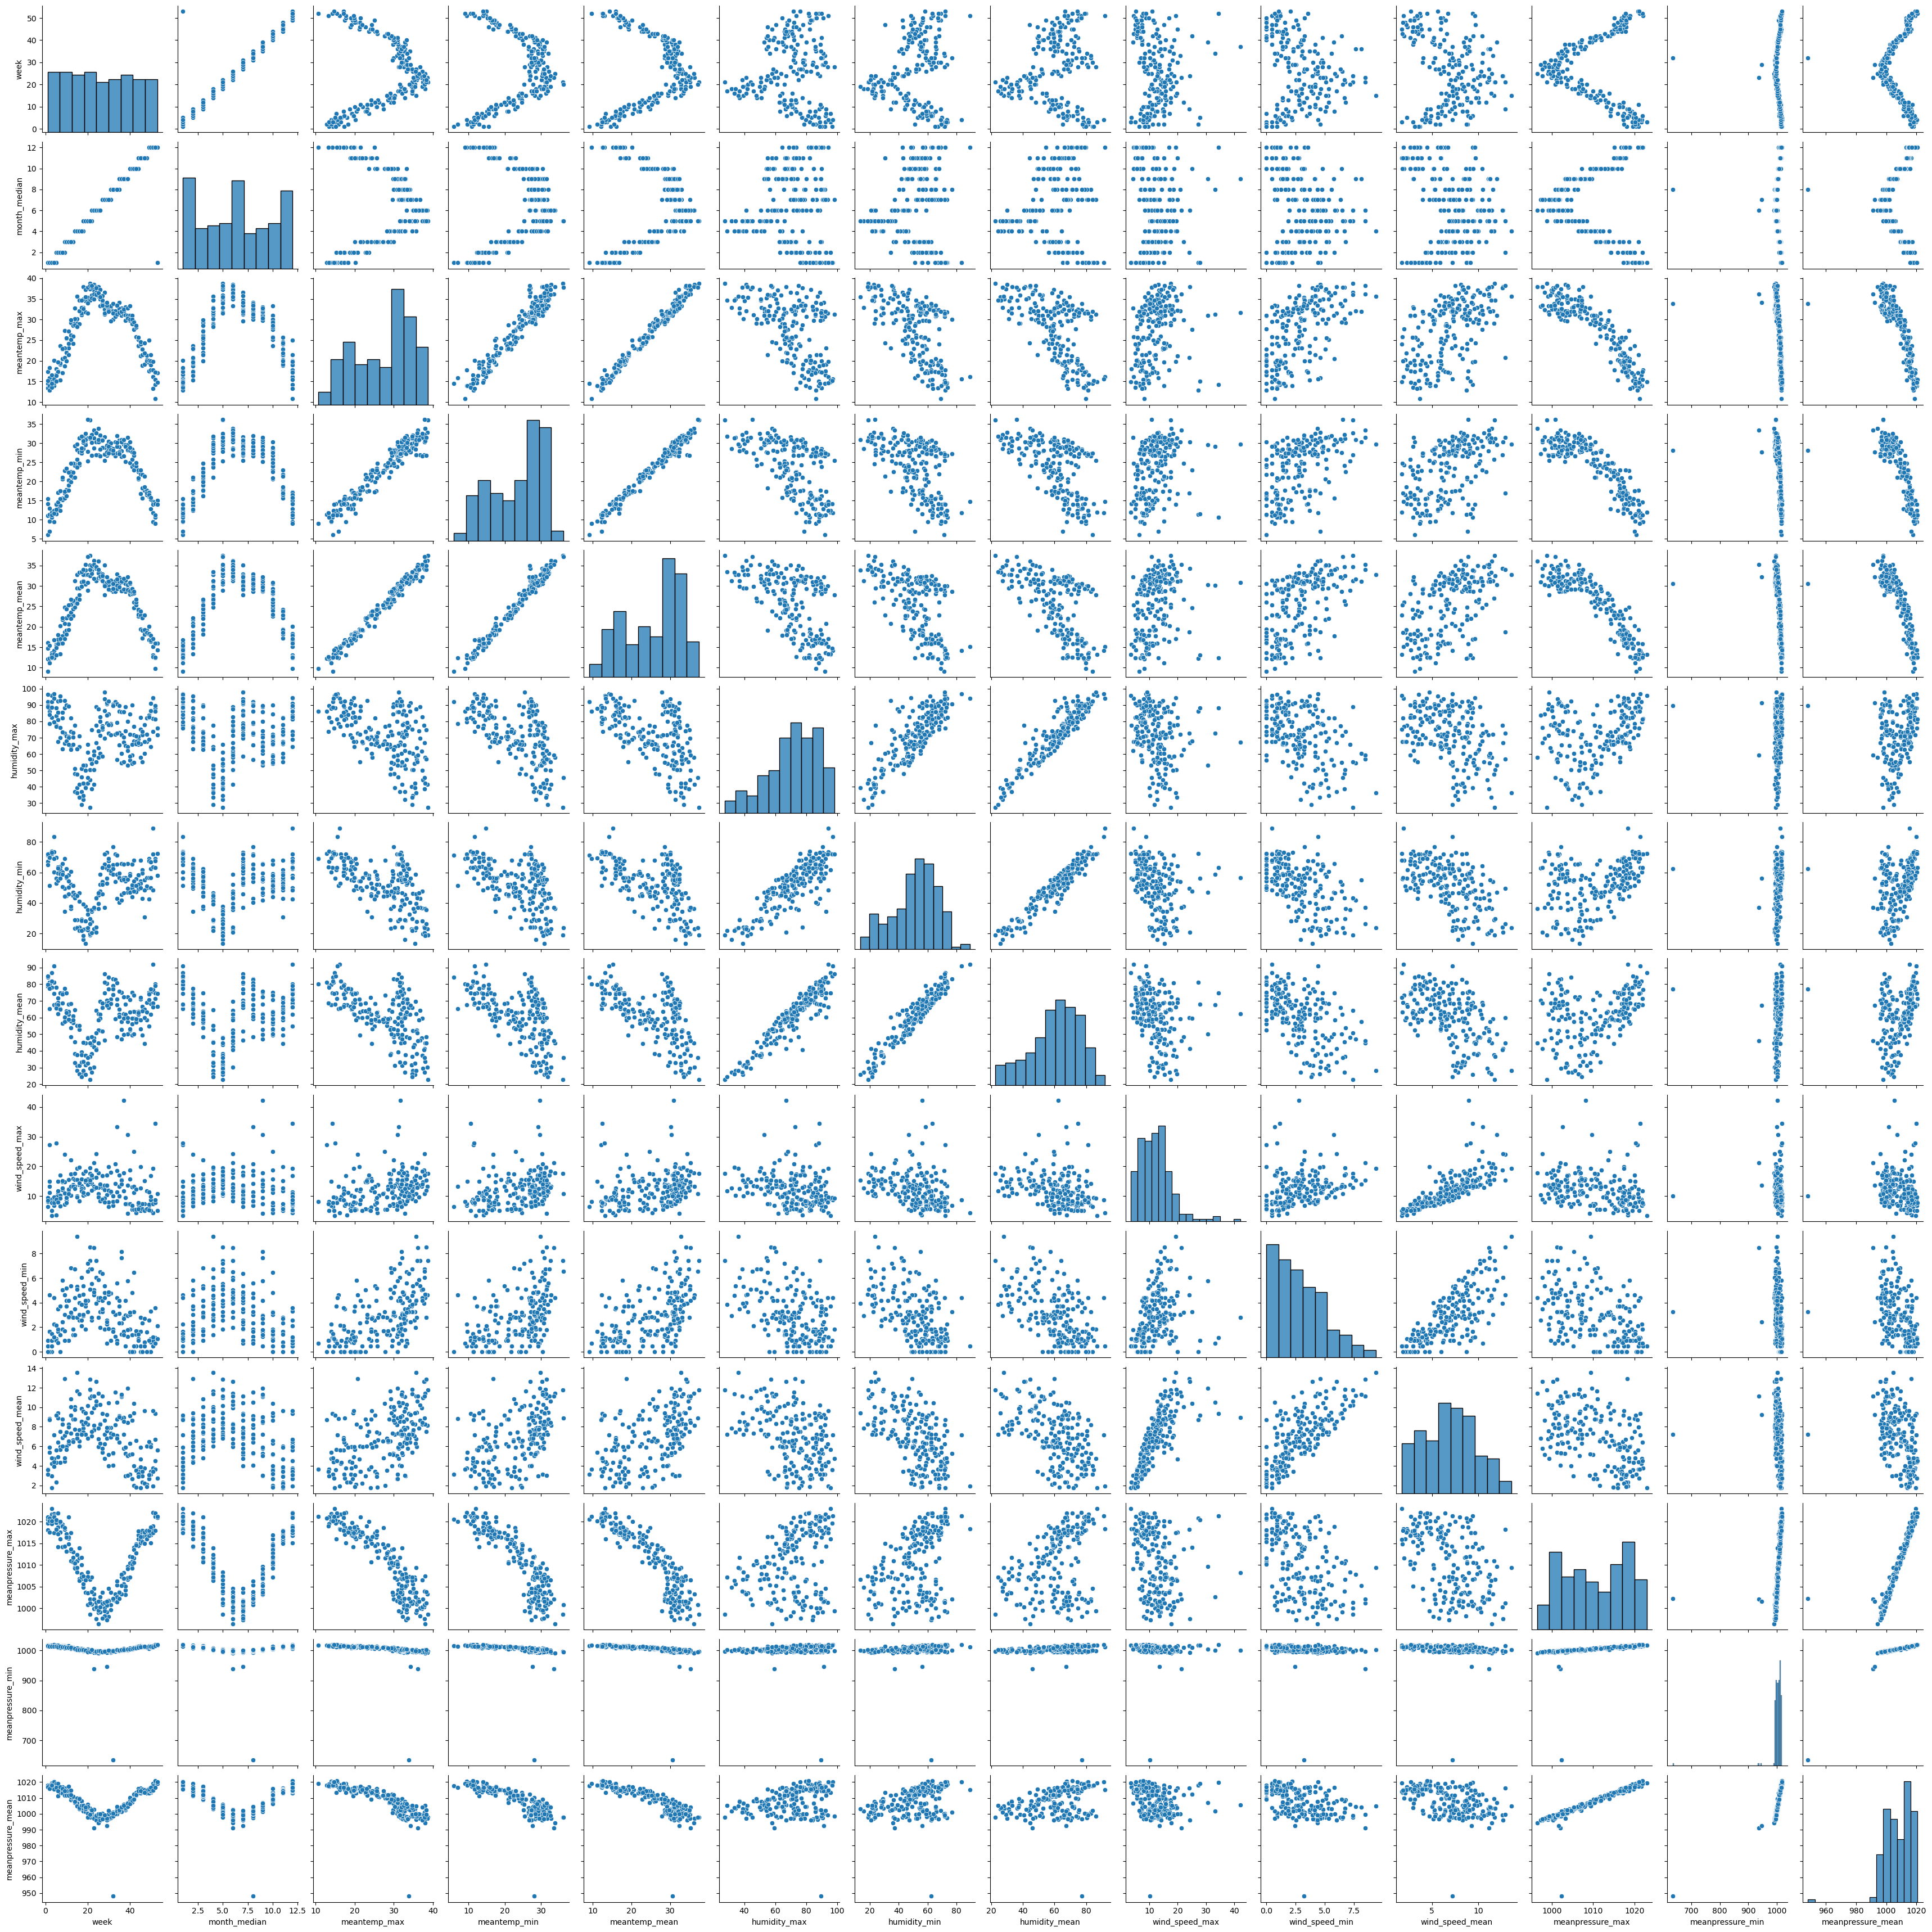

In [17]:
sns.pairplot(df[cols])

In [18]:
df.corr()

,week,year,meantemp_max,meantemp_min,meantemp_mean,humidity_max,humidity_min,humidity_mean,wind_speed_max,wind_speed_min,wind_speed_mean,meanpressure_max,meanpressure_min,meanpressure_mean,month_median
week,1.000000,0.002560,0.095230,0.160044,0.127092,0.029445,0.122550,0.079937,-0.105847,-0.216692,-0.241313,-0.111193,-0.043420,-0.086685,0.969115
year,0.002560,1.000000,0.072761,0.087409,0.082891,-0.101481,-0.049146,-0.077900,-0.054558,0.083162,0.022936,0.046138,-0.100700,-0.009071,-0.011614
meantemp_max,0.095230,0.072761,1.000000,0.961836,0.990331,-0.522731,-0.607341,-0.608461,0.267300,0.555129,0.526414,-0.901077,-0.318003,-0.815834,0.132498
meantemp_min,0.160044,0.087409,0.961836,1.000000,0.986430,-0.572793,-0.561109,-0.601744,0.258598,0.524817,0.487794,-0.878331,-0.293898,-0.783956,0.188226
meantemp_mean,0.127092,0.082891,0.990331,0.986430,1.000000,-0.544008,-0.589664,-0.609844,0.263936,0.542723,0.512690,-0.901737,-0.306709,-0.808937,0.160031
humidity_max,0.029445,-0.101481,-0.522731,-0.572793,-0.544008,1.000000,0.827206,0.933677,-0.209591,-0.463517,-0.404956,0.273811,0.005089,0.215528,0.020209
humidity_min,0.122550,-0.049146,-0.607341,-0.561109,-0.589664,0.827206,1.000000,0.959722,-0.311204,-0.537015,-0.551718,0.375276,0.072155,0.325632,0.095217
humidity_mean,0.079937,-0.077900,-0.608461,-0.601744,-0.609844,0.933677,0.959722,1.000000,-0.291357,-0.541706,-0.534345,0.360950,0.042734,0.300273,0.060835
wind_speed_max,-0.105847,-0.054558,0.267300,0.258598,0.263936,-0.209591,-0.311204,-0.291357,1.000000,0.322000,0.743243,-0.237383,-0.057079,-0.203492,-0.090576
wind_speed_min,-0.216692,0.083162,0.555129,0.524817,0.542723,-0.463517,-0.537015,-0.541706,0.322000,1.000000,0.747876,-0.477439,-0.166466,-0.436121,-0.195635


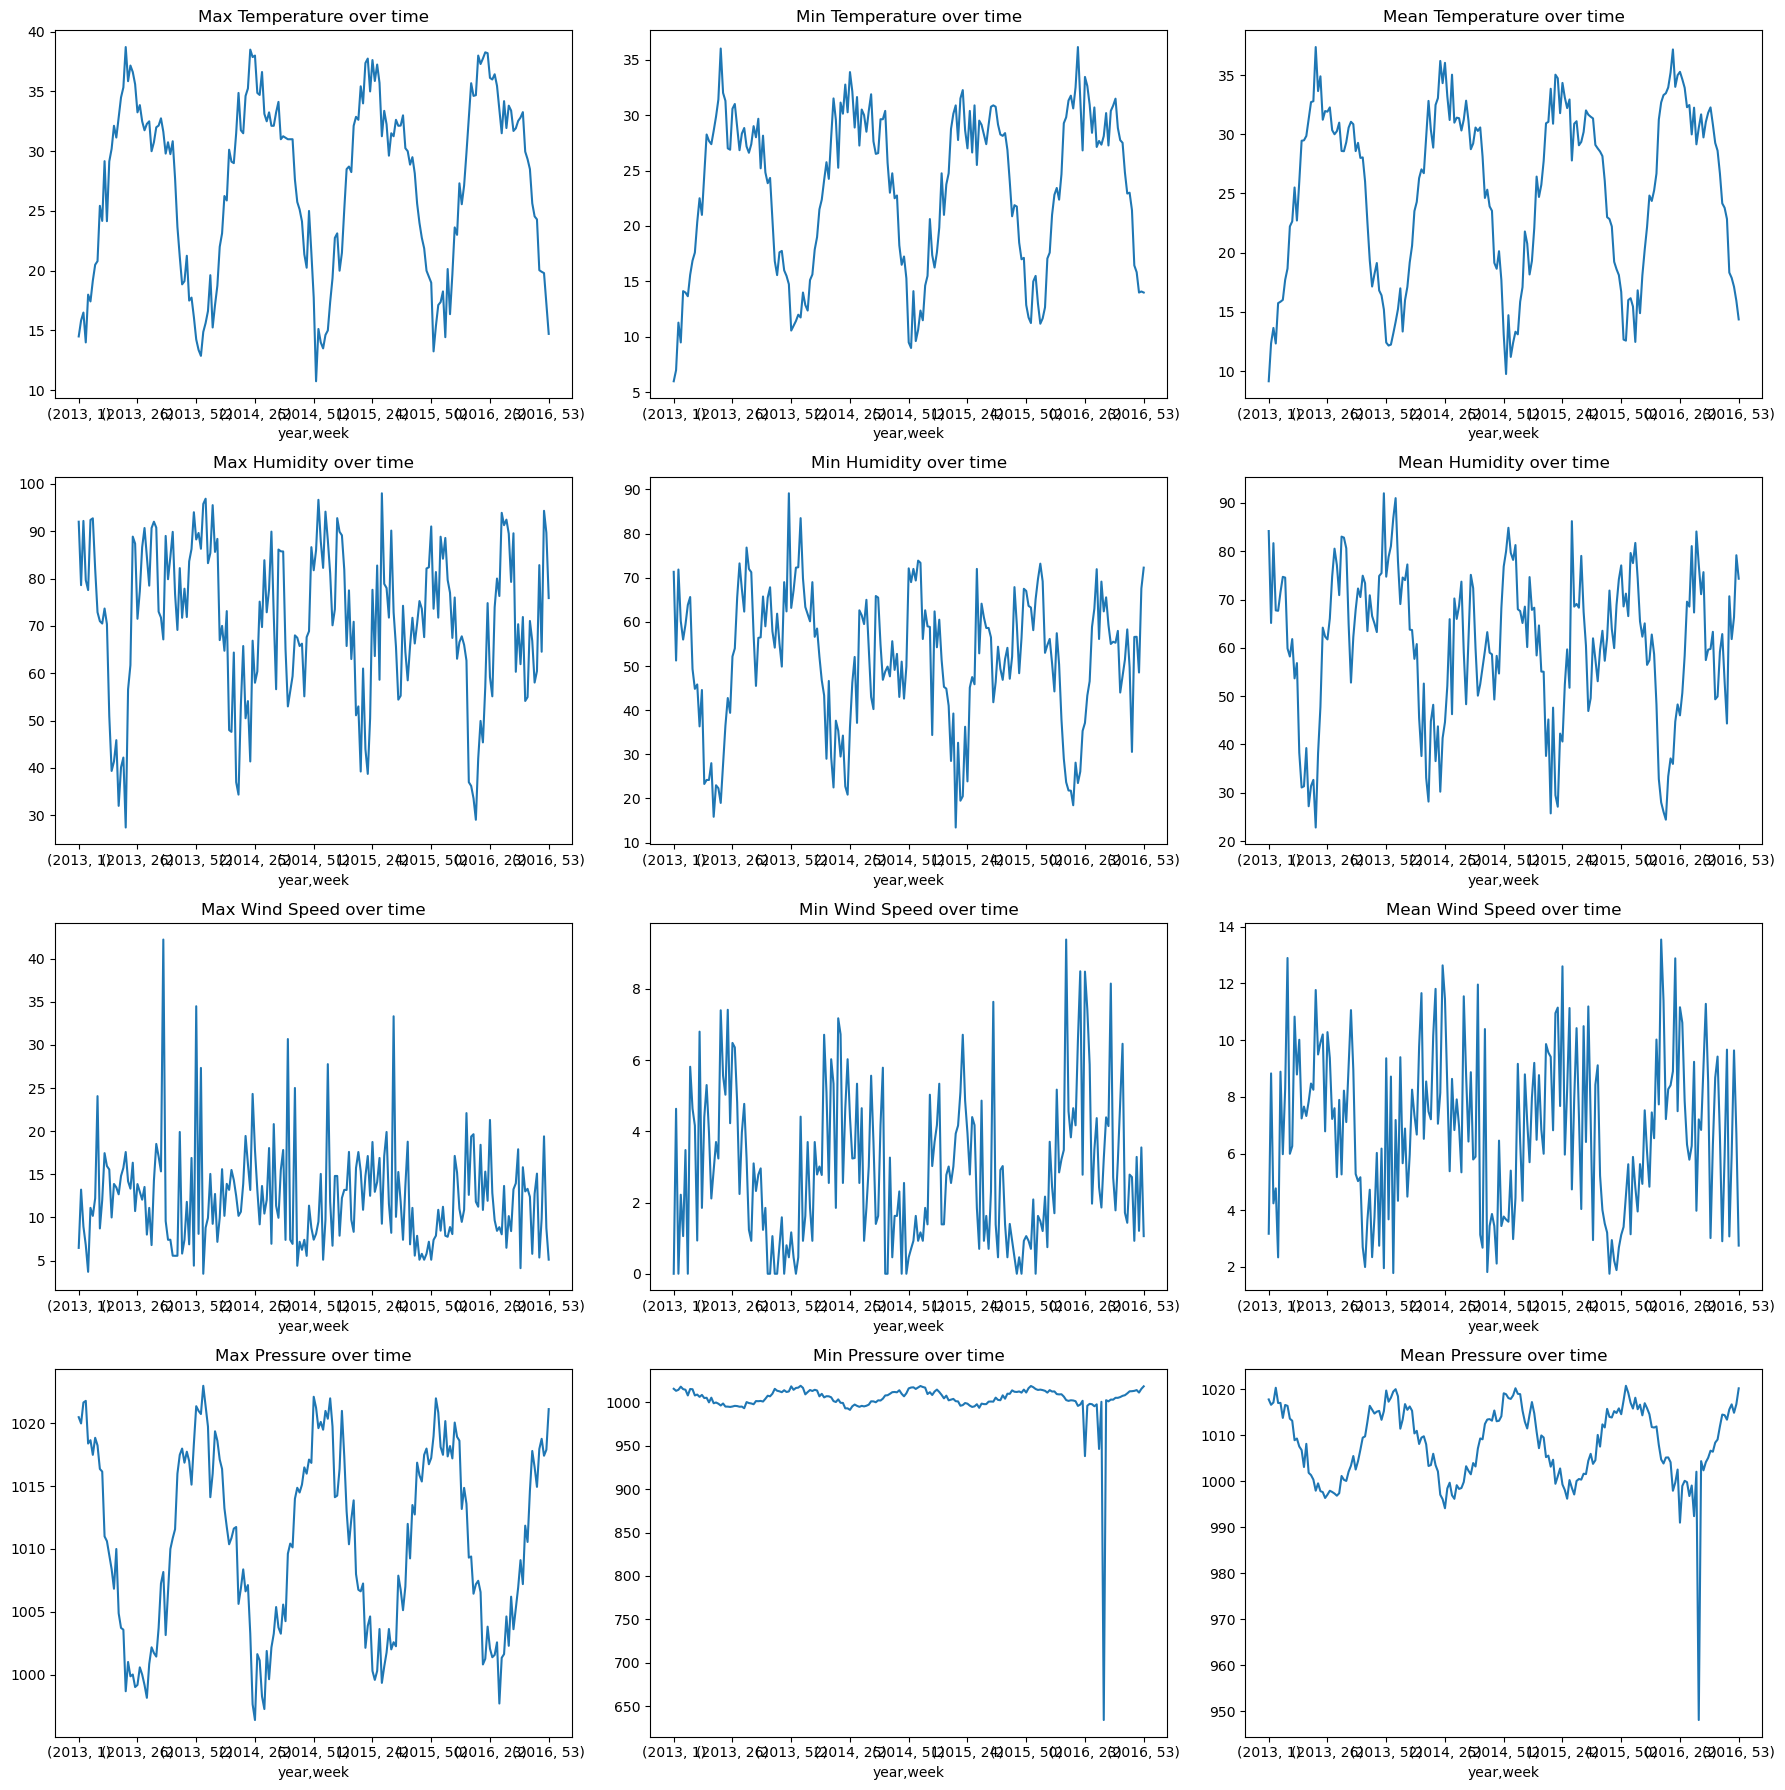

In [19]:
fig, axs = plt.subplots(4, 3, figsize=(18, 18))

df.set_index(['year', 'week'])['meantemp_max'].plot(ax=axs[0, 0], title='Max Temperature over time')
df.set_index(['year', 'week'])['meantemp_min'].plot(ax=axs[0, 1], title='Min Temperature over time')
df.set_index(['year', 'week'])['meantemp_mean'].plot(ax=axs[0, 2], title='Mean Temperature over time')

df.set_index(['year', 'week'])['humidity_max'].plot(ax=axs[1, 0], title='Max Humidity over time')
df.set_index(['year', 'week'])['humidity_min'].plot(ax=axs[1, 1], title='Min Humidity over time')
df.set_index(['year', 'week'])['humidity_mean'].plot(ax=axs[1, 2], title='Mean Humidity over time')

df.set_index(['year', 'week'])['wind_speed_max'].plot(ax=axs[2, 0], title='Max Wind Speed over time')
df.set_index(['year', 'week'])['wind_speed_min'].plot(ax=axs[2, 1], title='Min Wind Speed over time')
df.set_index(['year', 'week'])['wind_speed_mean'].plot(ax=axs[2, 2], title='Mean Wind Speed over time')

df.set_index(['year', 'week'])['meanpressure_max'].plot(ax=axs[3, 0], title='Max Pressure over time')
df.set_index(['year', 'week'])['meanpressure_min'].plot(ax=axs[3, 1], title='Min Pressure over time')
df.set_index(['year', 'week'])['meanpressure_mean'].plot(ax=axs[3, 2], title='Mean Pressure over time')

plt.tight_layout()
plt.show()

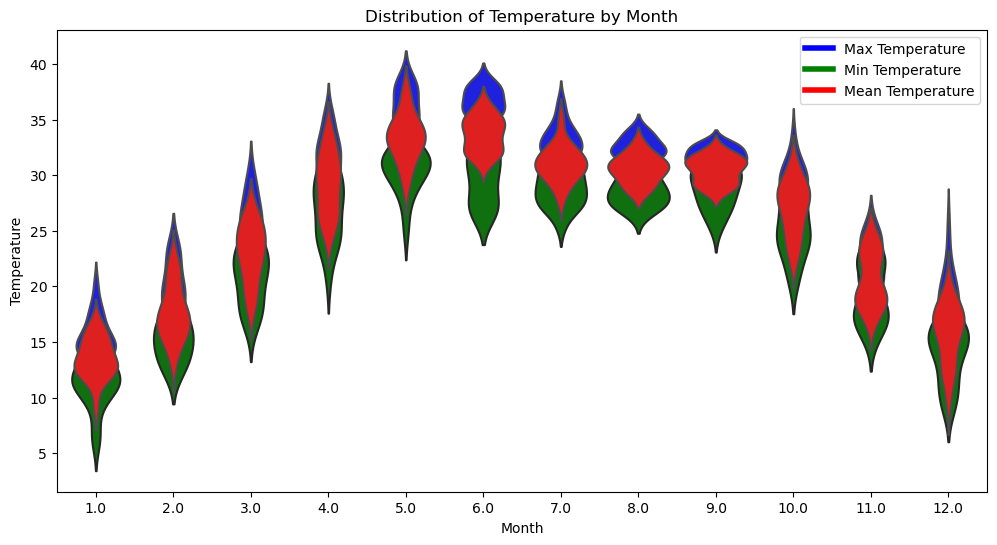

In [20]:
plt.figure(figsize=(12, 6))

sns.violinplot(x='month_median', y='meantemp_max', data=df, color='blue', label='Max Temperature', inner=None)

sns.violinplot(x='month_median', y='meantemp_min', data=df, color='green', label='Min Temperature', inner=None)

sns.violinplot(x='month_median', y='meantemp_mean', data=df, color='red', label='Mean Temperature', inner=None)

plt.title('Distribution of Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Temperature')

plt.legend(handles=[
    plt.Line2D([0], [0], color='blue', lw=4, label='Max Temperature'),
    plt.Line2D([0], [0], color='green', lw=4, label='Min Temperature'),
    plt.Line2D([0], [0], color='red', lw=4, label='Mean Temperature')
])

plt.show()

In [21]:
df = pd.get_dummies(df, columns=['month_median', 'week'], drop_first=True, dtype=int)

# Model

In [49]:
df['y'] = df['meantemp_mean'].shift(1)
df.dropna(inplace=True)

In [50]:
X = df.drop(columns=['year', 'meantemp_mean','y','meantemp_max','meantemp_min'])
y = df['y']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [53]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [54]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)
loss = model.evaluate(X_test, y_test)
print(f"Mean Squared Error: {loss}")

Epoch 1/50
11/11 [==============================] - 0s 8ms/step - loss: 654.6341 - val_loss: 601.2349
Epoch 2/50
11/11 [==============================] - 0s 2ms/step - loss: 588.9100 - val_loss: 544.0961
Epoch 3/50
11/11 [==============================] - 0s 2ms/step - loss: 525.2186 - val_loss: 484.0906
Epoch 4/50
11/11 [==============================] - 0s 2ms/step - loss: 451.4564 - val_loss: 417.0378
Epoch 5/50
11/11 [==============================] - 0s 2ms/step - loss: 369.5378 - val_loss: 341.1074
Epoch 6/50
11/11 [==============================] - 0s 2ms/step - loss: 277.7127 - val_loss: 260.1538
Epoch 7/50
11/11 [==============================] - 0s 2ms/step - loss: 184.9834 - val_loss: 180.9294
Epoch 8/50
11/11 [==============================] - 0s 2ms/step - loss: 105.9589 - val_loss: 112.8720
Epoch 9/50
11/11 [==============================] - 0s 2ms/step - loss: 50.9608 - val_loss: 66.1407
Epoch 10/50
11/11 [==============================] - 0s 2ms/step - loss: 22.9884 - v

In [55]:
y_pred = model.predict(X_test)
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

2/2 [==============================] - 0s 2ms/step
        Actual  Predicted
174  26.051020  25.244827
62   25.732143  25.842796
80   32.795238  31.670246
113  35.035714  29.592110
23   14.889494   4.953056


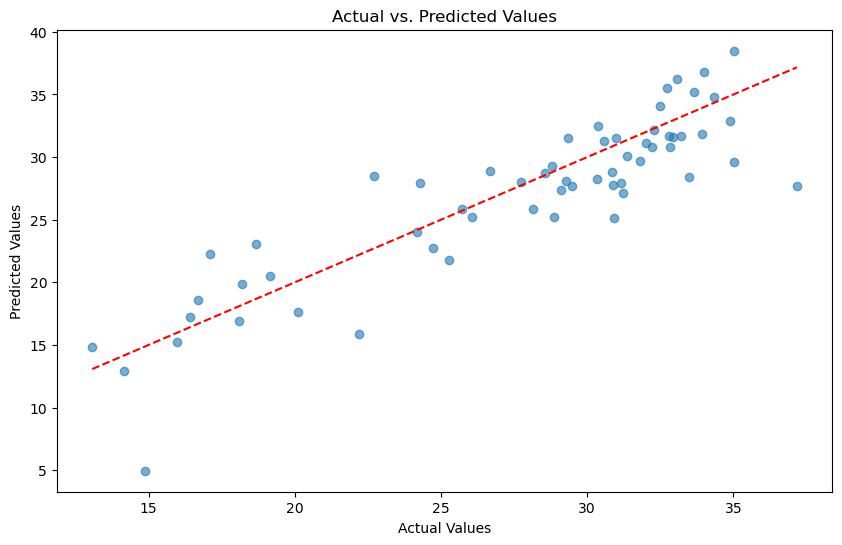

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

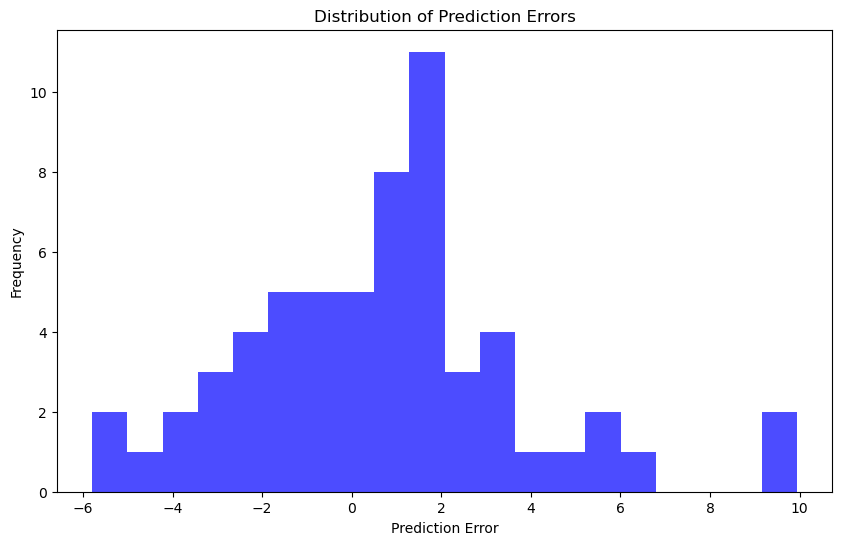

In [57]:
errors = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=20, alpha=0.7, color='blue')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()